In [64]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
def plot_time_series(data, activity):
    """
    Plots the 3 channels of the time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    # Extract time and accelerometer data from the activity of standing + stairs
    time = data.iloc[:, 0]  # First column: Time
    x = data.iloc[:, 1]     # Second column: X-axis acceleration
    y = data.iloc[:, 2]     # Third column: Y-axis acceleration
    z = data.iloc[:, 3]     # Fourth column: Z-axis acceleration

    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot X-axis acceleration
    axes[0].plot(time, x, color='r', label="X-axis")
    axes[0].set_ylabel("Acceleration (X)")
    axes[0].legend()
    axes[0].grid()

    # Plot Y-axis acceleration
    axes[1].plot(time, y, color='g', label="Y-axis")
    axes[1].set_ylabel("Acceleration (Y)")
    axes[1].legend()
    axes[1].grid()

    # Plot Z-axis acceleration
    axes[2].plot(time, z, color='b', label="Z-axis")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Acceleration (Z)")
    axes[2].legend()
    axes[2].grid()

    # Title for the whole figure
    plt.suptitle(f"Accelerometer Time Series ({activity})")

    # Show plot
    plt.show()

In [66]:
def plot_cwt_spectrograms(data, wavelet, activity):
    """
    Plots the Continuous Wavelet Transform (CWT) spectrograms for the given time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    # Extract time and accelerometer data
    time = data.iloc[:, 0]  # First column: Time
    x = data.iloc[:, 1]     # Second column: X-axis acceleration
    y = data.iloc[:, 2]     # Third column: Y-axis acceleration
    z = data.iloc[:, 3]     # Fourth column: Z-axis acceleration

    # Define scales
    fs = 52  # Sampling frequency
    f_min, f_max = 1, 36  # Frequency range of interest
    C_f = 0.25  # Mexican Hat wavelet-specific constant

    scale_min = fs / (f_max * C_f)  # Smallest scale (high freq)
    scale_max = fs / (f_min * C_f)  # Largest scale (low freq)

    scales = np.linspace(scale_min, scale_max, num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, _ = pywt.cwt(x, scales, wavelet)
    coeff_y, _ = pywt.cwt(y, scales, wavelet)
    coeff_z, _ = pywt.cwt(z, scales, wavelet)

    # Plot CWT spectrograms (scalograms)
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # X-axis scalogram
    cax_x = axes[0].imshow(np.abs(coeff_x), aspect='auto', extent=[time.min(), time.max(), scales.max(), scales.min()], cmap='jet')
    axes[0].set_title("CWT Scalogram - X Axis")
    axes[0].set_ylabel("Scale (inverse frequency)")
    axes[0].grid()
    fig.colorbar(cax_x, ax=axes[0], orientation='vertical', label='Coefficient Magnitude')

    # Y-axis scalogram
    cax_y = axes[1].imshow(np.abs(coeff_y), aspect='auto', extent=[time.min(), time.max(), scales.max(), scales.min()], cmap='jet')
    axes[1].set_title("CWT Scalogram - Y Axis")
    axes[1].set_ylabel("Scale (inverse frequency)")
    axes[1].grid()
    fig.colorbar(cax_y, ax=axes[1], orientation='vertical', label='Coefficient Magnitude')

    # Z-axis scalogram
    cax_z = axes[2].imshow(np.abs(coeff_z), aspect='auto', extent=[time.min(), time.max(), scales.max(), scales.min()], cmap='jet')
    axes[2].set_title("CWT Scalogram - Z Axis")
    axes[2].set_ylabel("Scale (inverse frequency)")
    axes[2].set_xlabel("Time")
    axes[2].grid()
    fig.colorbar(cax_z, ax=axes[2], orientation='vertical', label='Coefficient Magnitude')

    # Title for the whole figure
    plt.suptitle(f"CWT Spectrograms ({activity})")

    # Show the figure
    plt.tight_layout()
    plt.show()


In [67]:
# Load the data from the CSV file
data = pd.read_csv('./dataset/9.csv', header=None)

# separate the data into 7 different structures, one for each different activity
working_pc = data[data.iloc[:, 4] == 1]
standing_stairs = data[data.iloc[:, 4] == 2]
standing = data[data.iloc[:, 4] == 3]
walking = data[data.iloc[:, 4] == 4]
stairs = data[data.iloc[:, 4] == 5]
walking_talking = data[data.iloc[:, 4] == 6]
standing_talking = data[data.iloc[:, 4] == 7]

# For each activity, remove the last column
working_pc = working_pc.iloc[:, :-1]
standing_stairs = standing_stairs.iloc[:, :-1]
standing = standing.iloc[:, :-1]
walking = walking.iloc[:, :-1]
stairs = stairs.iloc[:, :-1]
walking_talking = walking_talking.iloc[:, :-1]
standing_talking = standing_talking.iloc[:, :-1]

# For each activity, reset the value of the first column to start from 0 until the end
working_pc.iloc[:, 0] = np.arange(0, len(working_pc))
standing_stairs.iloc[:, 0] = np.arange(0, len(standing_stairs))
standing.iloc[:, 0] = np.arange(0, len(standing))
walking.iloc[:, 0] = np.arange(0, len(walking))
stairs.iloc[:, 0] = np.arange(0, len(stairs))
walking_talking.iloc[:, 0] = np.arange(0, len(walking_talking))
standing_talking.iloc[:, 0] = np.arange(0, len(standing_talking))


In [68]:
sombrero = pywt.ContinuousWavelet('mexh')
print(sombrero)

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


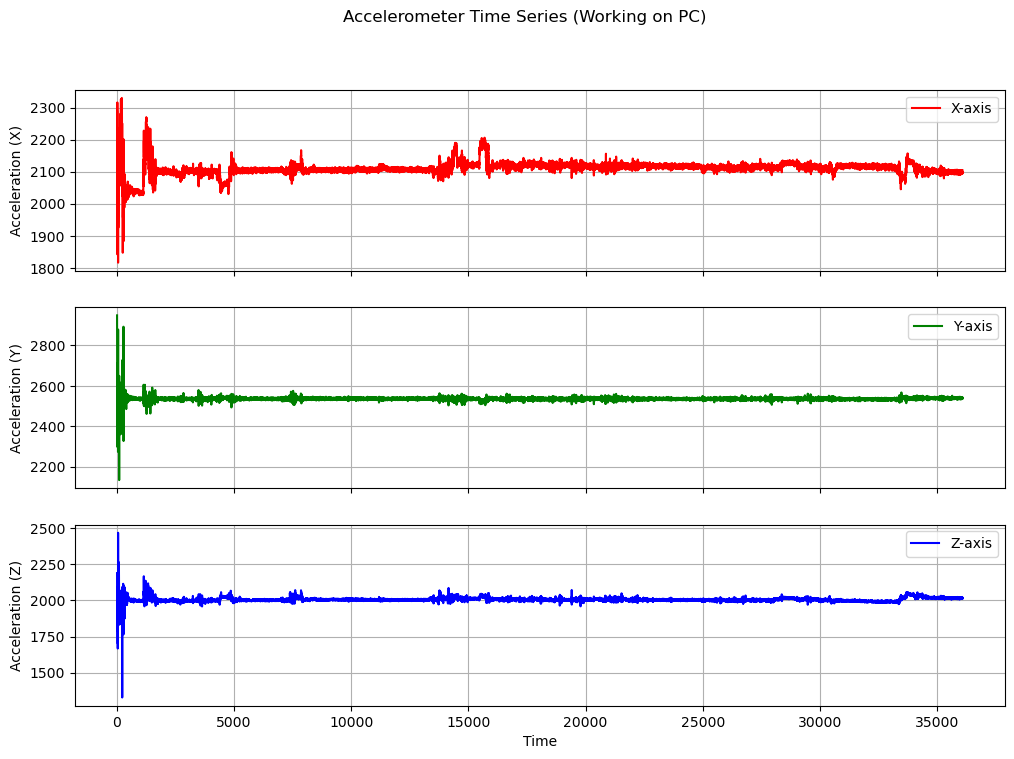

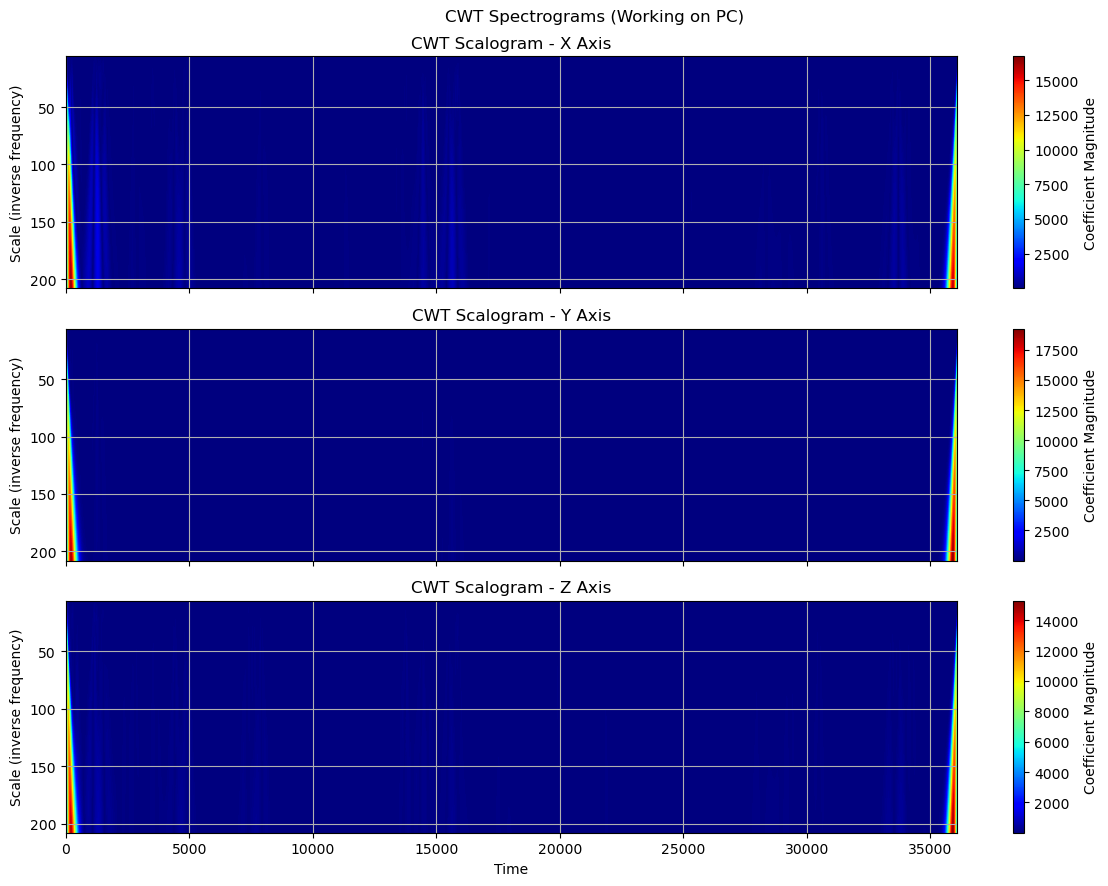

In [69]:
# Plot the time series data for the activity of working_pc
plot_time_series(working_pc, "Working on PC")
# Plot the CWT spectrograms for the activity of working_pc
plot_cwt_spectrograms(working_pc, sombrero, "Working on PC")

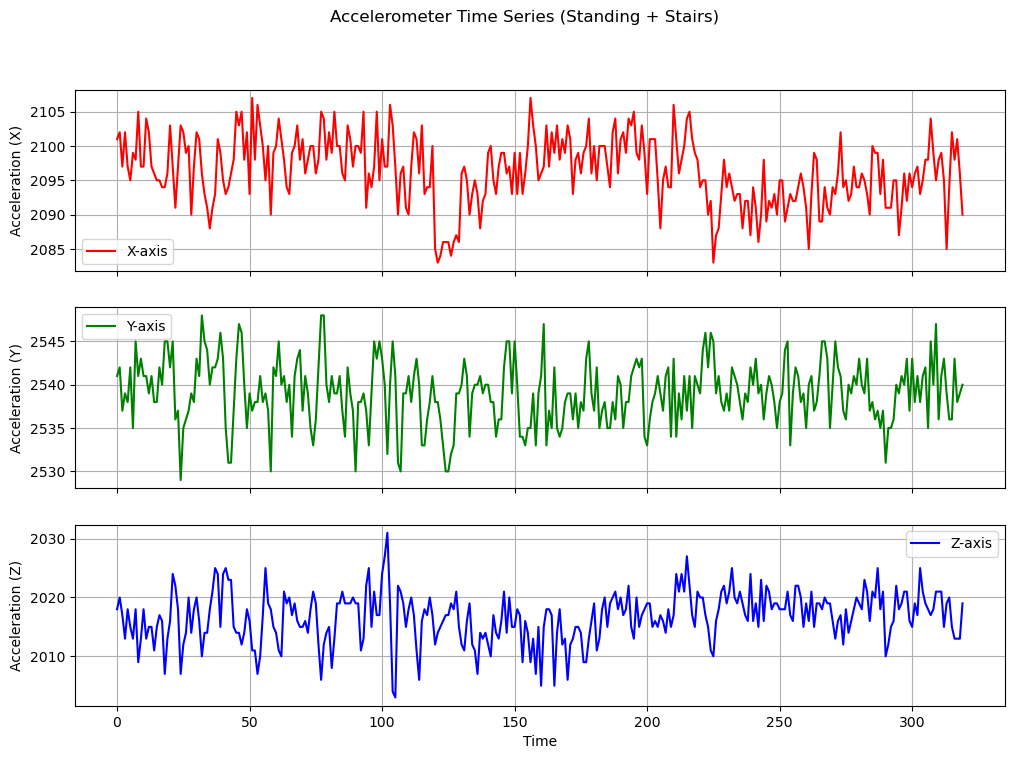

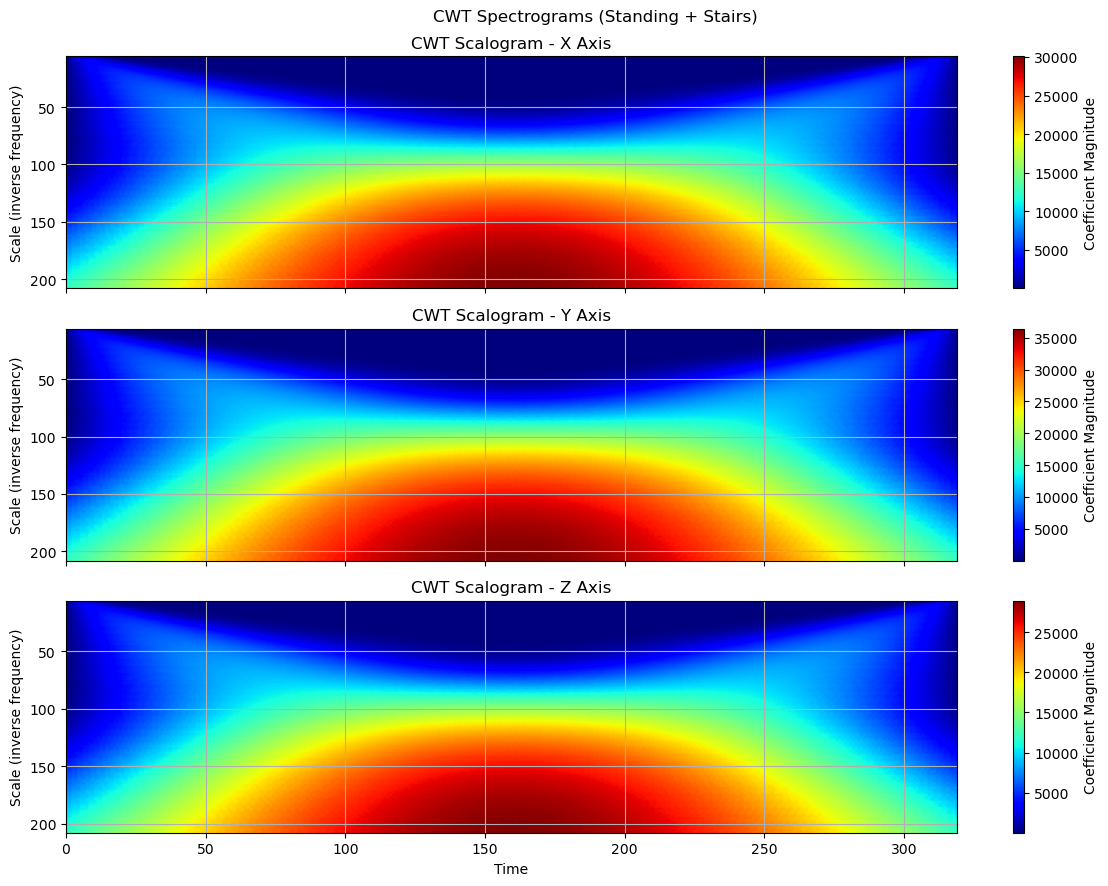

In [70]:
# Plot the time series data for the activity of standing + stairs
plot_time_series(standing_stairs, "Standing + Stairs")
# Plot the CWT spectrograms for the activity of standing + stairs
plot_cwt_spectrograms(standing_stairs, sombrero, "Standing + Stairs")


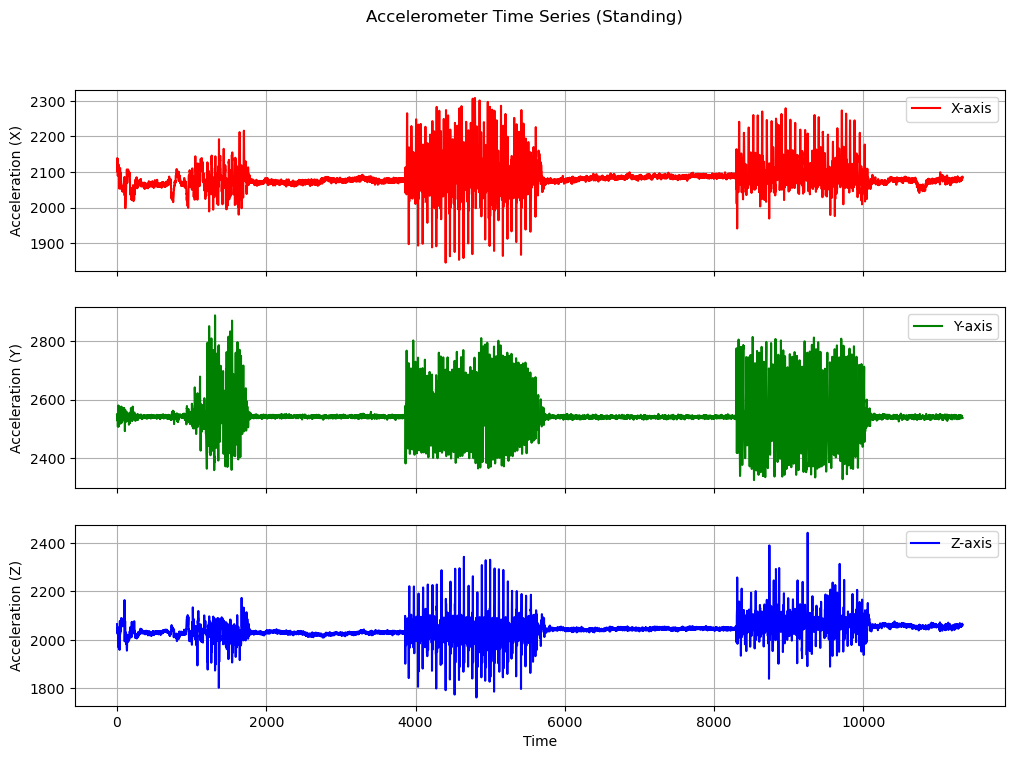

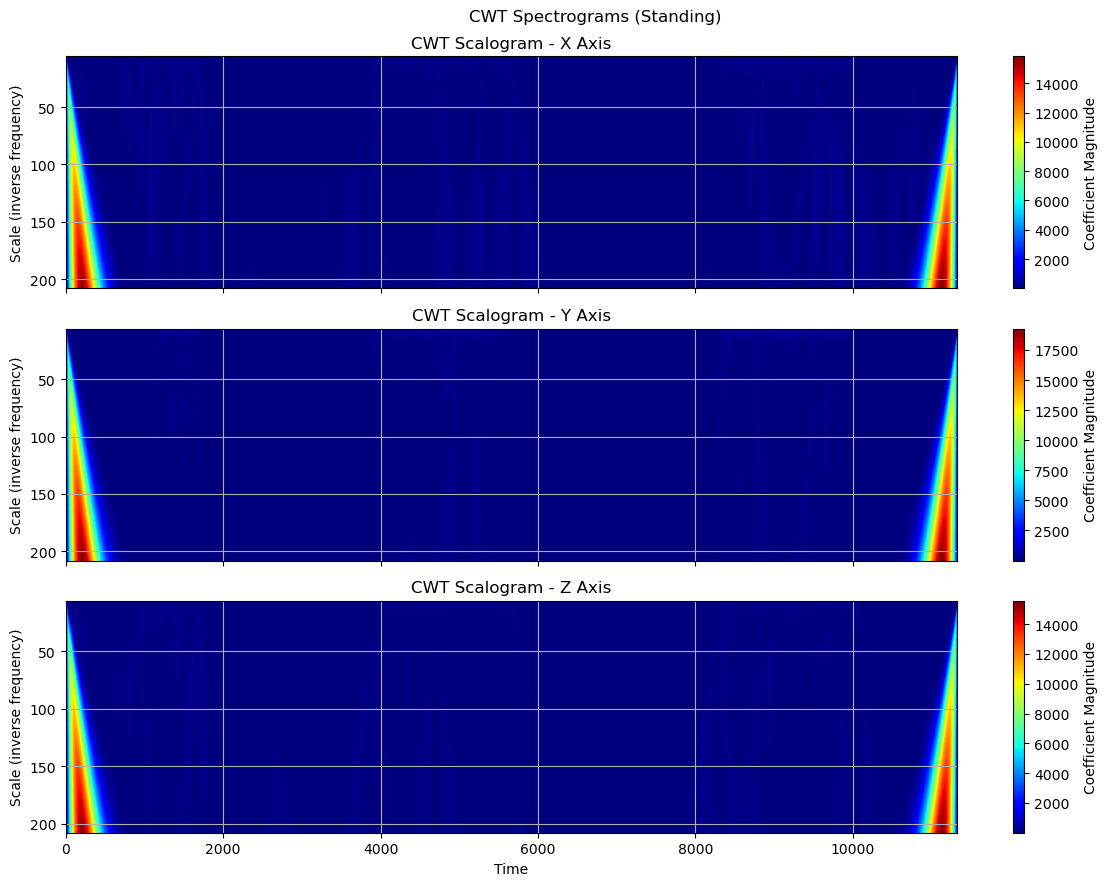

In [71]:
# Plot the time series data for the activity of standing
plot_time_series(standing, "Standing")
# plot the CWT spectrograms for the activity of standing
plot_cwt_spectrograms(standing, sombrero, "Standing")

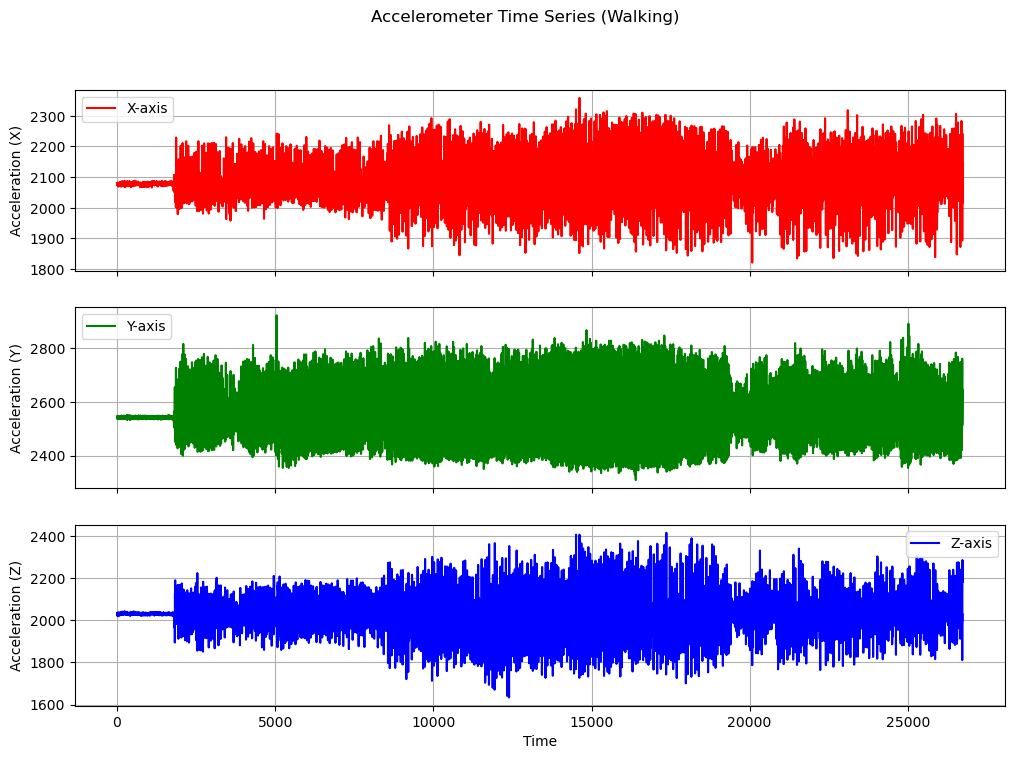

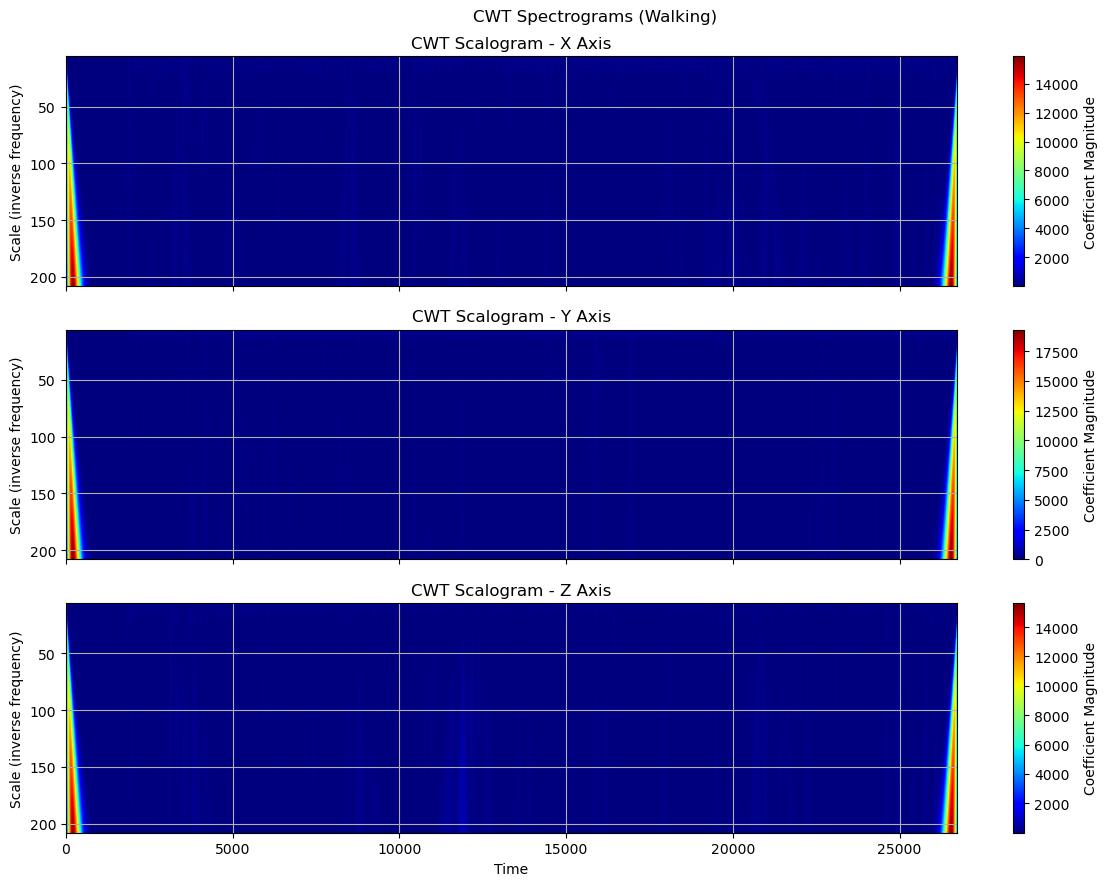

In [72]:
# plot the time series data for the activity of walking
plot_time_series(walking, "Walking")
# plot the CWT spectrograms for the activity of walking
plot_cwt_spectrograms(walking, sombrero, "Walking")


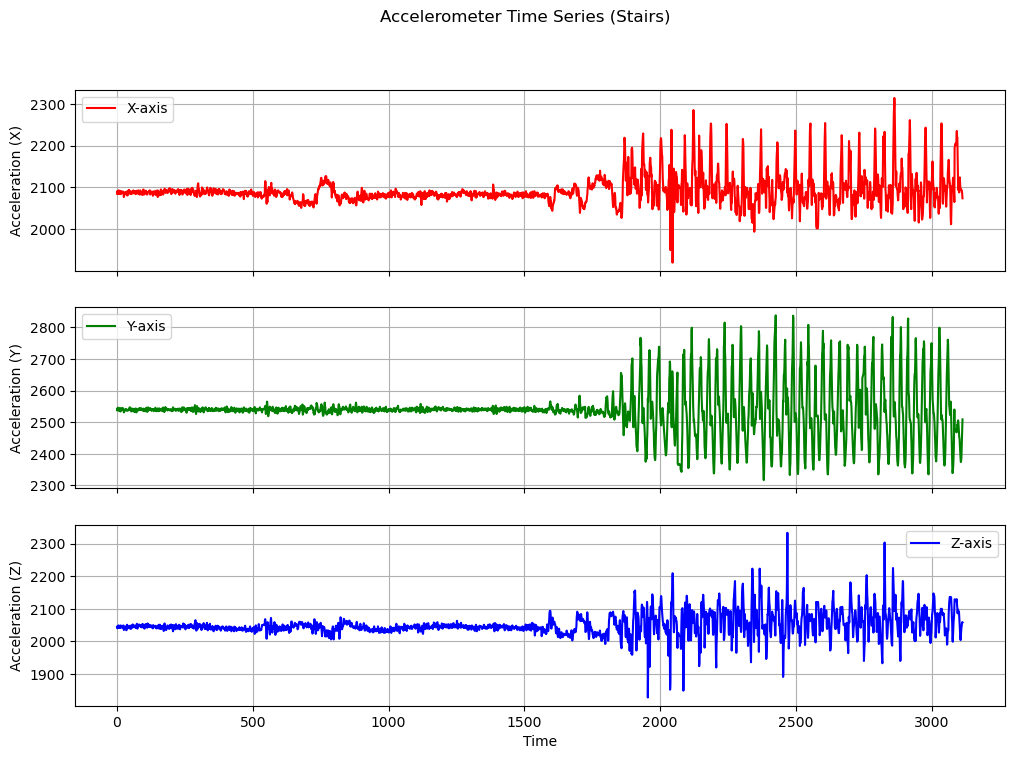

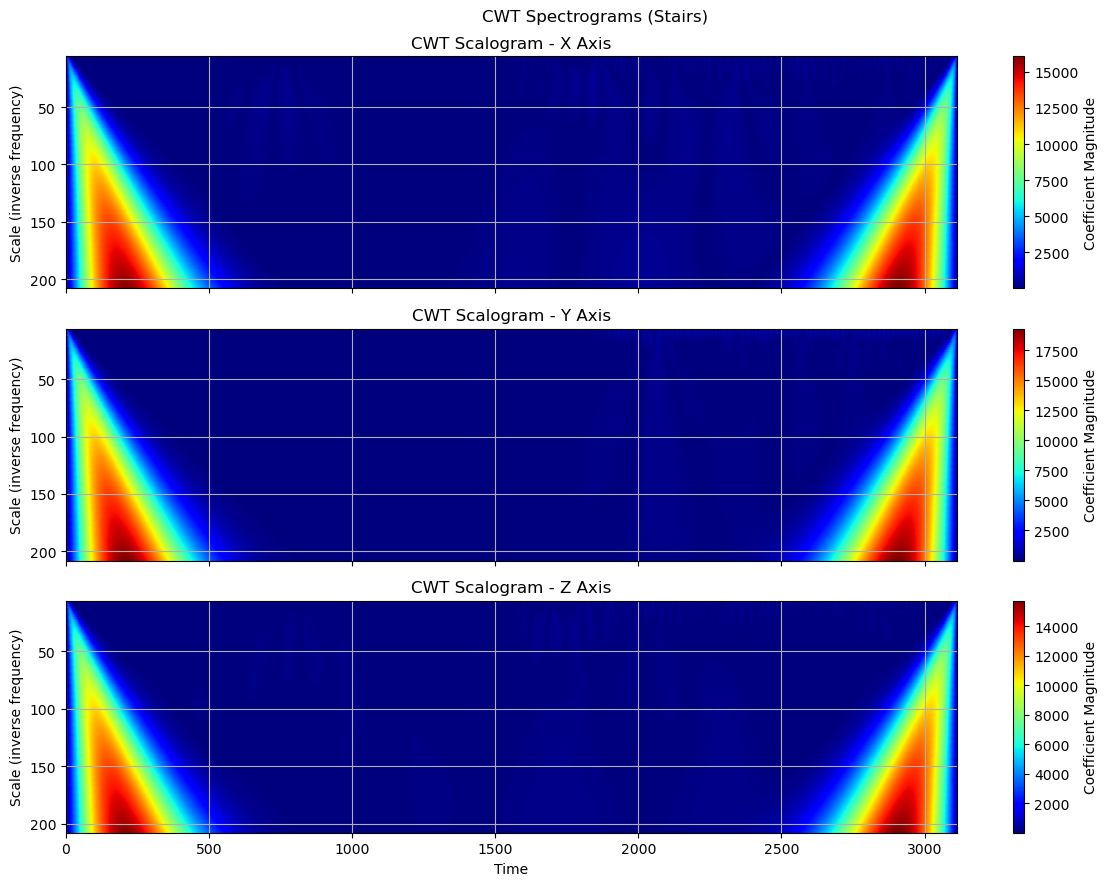

In [73]:
# plot the time series data for the activity of stairs
plot_time_series(stairs, "Stairs")
# plot the CWT spectrograms for the activity of stairs
plot_cwt_spectrograms(stairs, sombrero, "Stairs")

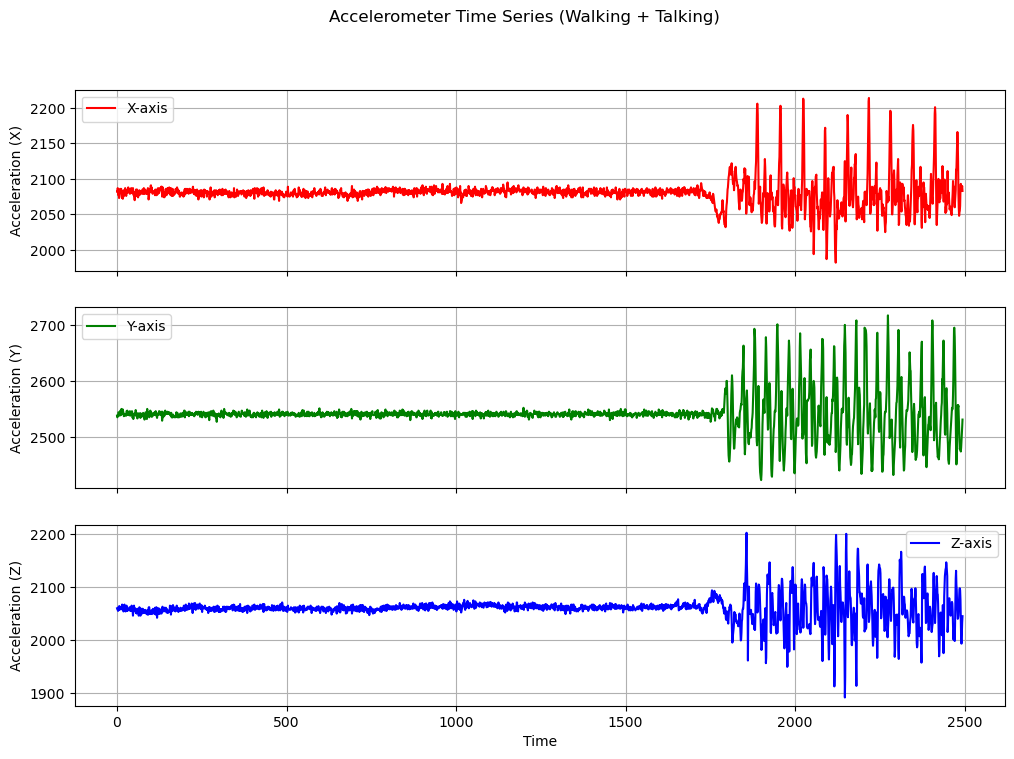

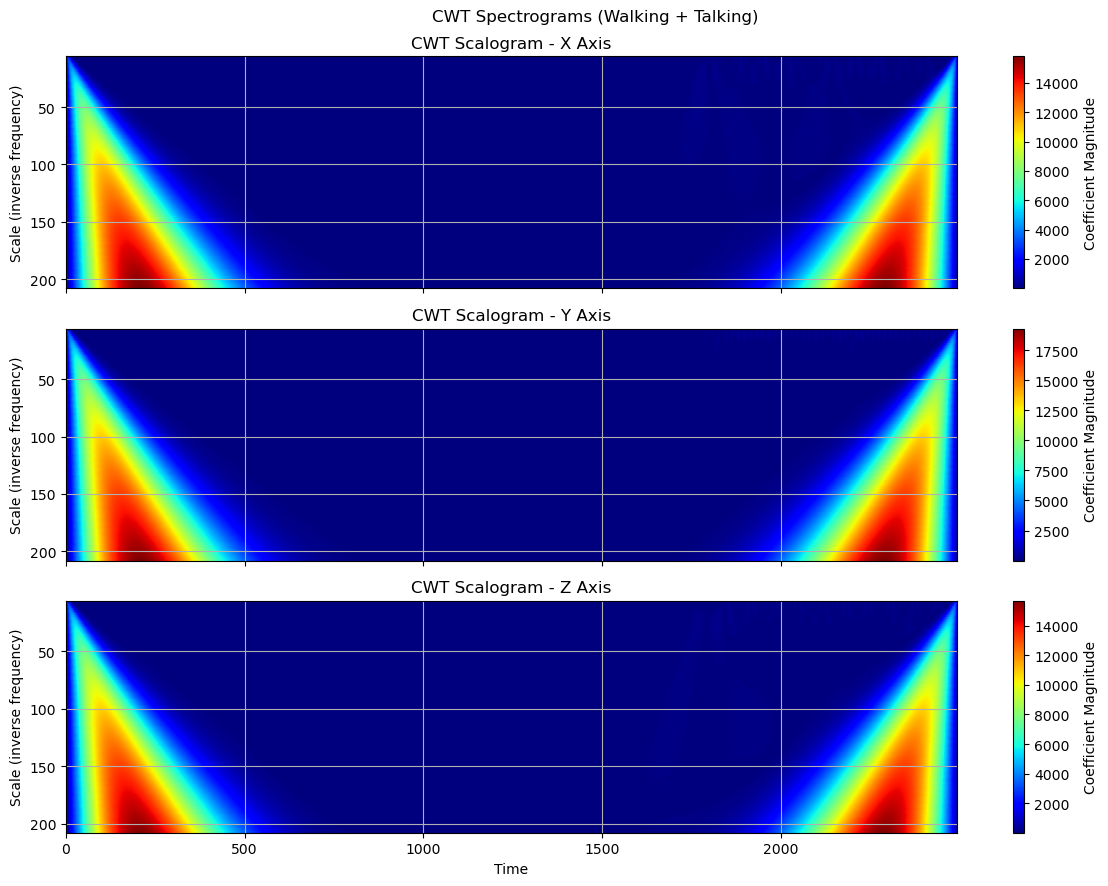

In [74]:
# plot the time series data for the activity of walking + talking
plot_time_series(walking_talking, "Walking + Talking")
# plot the CWT spectrograms for the activity of walking + talking
plot_cwt_spectrograms(walking_talking, sombrero, "Walking + Talking")

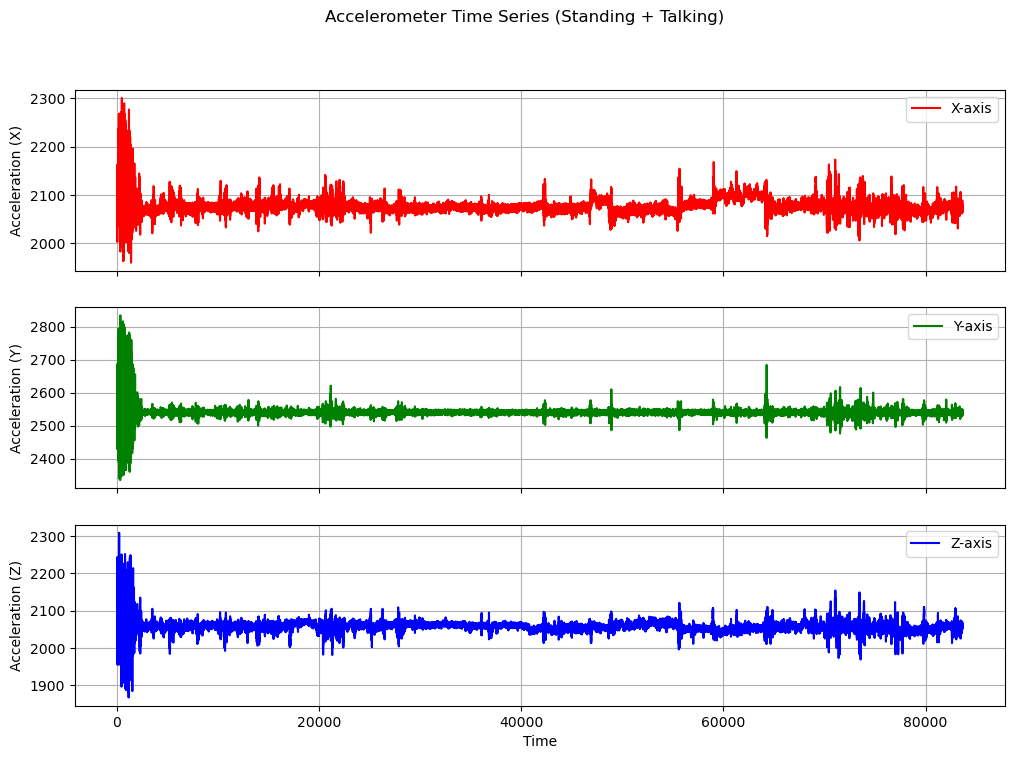

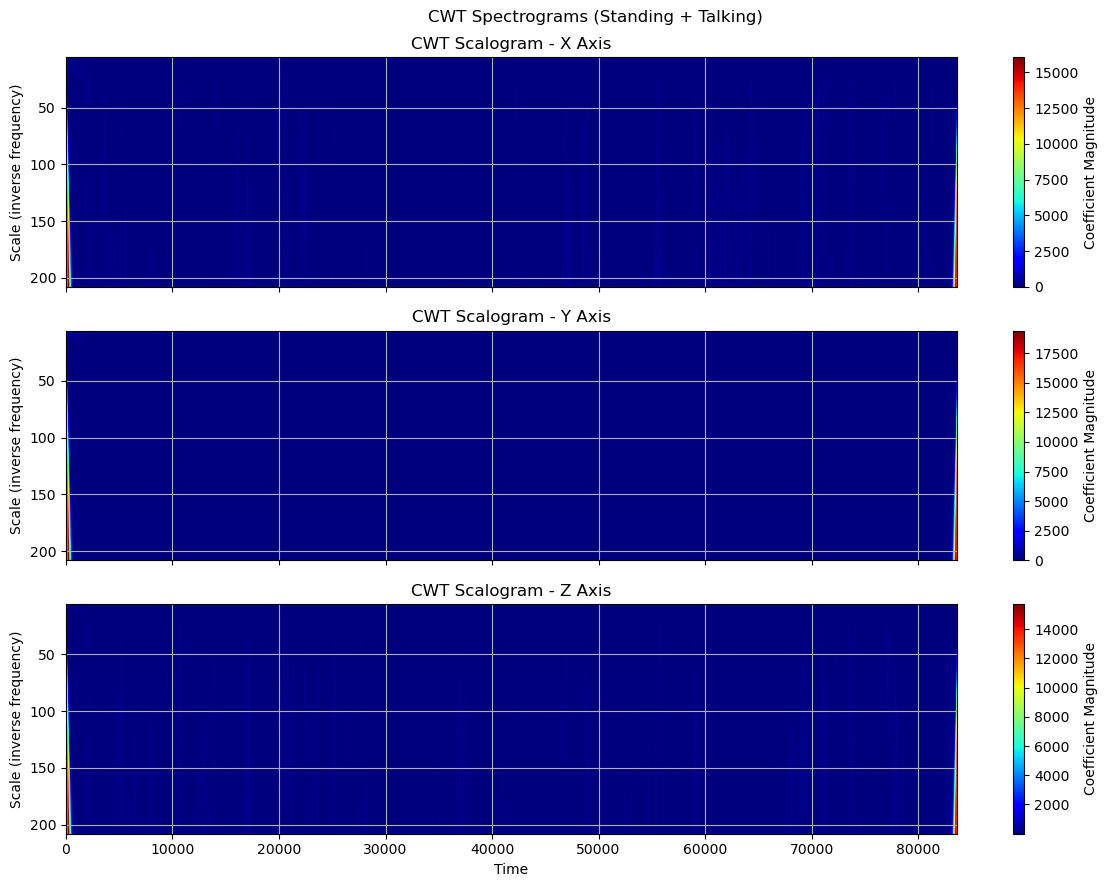

In [75]:
# plot the time series data for the activity of standing + talking
plot_time_series(standing_talking, "Standing + Talking")
# plot the CWT spectrograms for the activity of standing + talking
plot_cwt_spectrograms(standing_talking, sombrero, "Standing + Talking")